# <div style="font-family: Georgia, serif"><div style="text-align: center;color: #E67E02"><div><h1>Assignment 2</h1></div></div><div style="color: #0377DE; font-size: 20px"><span style="padding-right: 100px;">Name: Koushik Mahanta</span > <span>Roll No.: 002011001106</span></div></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.datasets import (load_iris, load_breast_cancer)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import (   
                                classification_report, 
                                confusion_matrix, 
                                accuracy_score, 
                                roc_curve, 
                                roc_auc_score,
                                auc
                            )

In [3]:
def printClassficationReport(dataset, classifier, random_state, trin_size, **args):
    """This function takes a model and its configurations and prints the 
    classification report and confusion matrix, if the classifier is a 
    DecisionTreeClassifier then it displays the tree"""
    
    X_train, X_test, y_train, y_test = train_test_split(dataset.data, 
                                                        dataset.target, 
                                                        train_size=trin_size, 
                                                        random_state=random_state)
    
    trained_model = classifier(**args).fit(X_train, y_train)
    y_prediction = trained_model.predict(X_test)

    print(f"======================== Model = {classifier.__name__} ========================")
    print("------------------------- Classification Report ----------------------")
    print(classification_report(y_test, 
                                y_prediction,  
                                labels=np.unique(y_prediction)))
    
    print("---------------------------- Confusion Mtrix -------------------------")
    plt.figure(figsize=(3, 2.5));
    cf_matrix = confusion_matrix(y_test, y_prediction)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), 
                annot=True, fmt='.2%', cmap='Blues')
    plt.show()
    print("\n\n")

In [4]:
def getModelScores(dataset, model_params, k_fold):
    """This function performs k_fold Grid search cross validation on 
    the dataset for all the models in `model_params` using all combinations 
    of configuraions mentioned for that model and returns a DataFrame 
    containing maximum test score configurations for each model"""
    scores = []
    for model_name, mp in model_params.items():
        clf =  GridSearchCV(mp['model'], mp['params'], 
                            cv=5, 
                            return_train_score=False)
        
        clf.fit(dataset.data, dataset.target)
        
        scores.append({
            'model': model_name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_
        })
        
    df = pd.DataFrame(scores,
                      columns=['model','best_score','best_params'])
    return df

In [5]:
def getTrainsizeAccuracies(dataset, 
                           classifier, 
                           random_state,
                           /, *, 
                           train_sizes=[0.3, 0.4, 0.5, 0.6, 0.7],
                           **args
                          ):
    
    """Z
        This function takes a dataset, a classifier and an optional array containing 
        traing sizes. It computes model accuracy scores for each train-test split and
        displays a Model accuracy vs Training size plot
    """
    accuracies = []
    for train_size in train_sizes:
        X_train, X_test, y_train, y_test = train_test_split(dataset.data, 
                                                            dataset.target, 
                                                            train_size=train_size, 
                                                            random_state=random_state)
        if args:
            trained_model = classifier(**args).fit(X_train, y_train)
        else:
            trained_model = classifier().fit(X_train, y_train)
        y_prediction = trained_model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_prediction))
        
    # Plotting the Graph
    plt.figure(figsize=(3, 2.5));
    plt.plot(np.array(train_sizes)*100, np.array(accuracies)*100)
    plt.title("Model Accuracy vs Training Size (Model = {0})"
              .format(classifier.__name__))
    plt.xlabel("Training Size (%)")
    plt.ylabel("Model Accuracy (%)")
    plt.xticks(np.array(train_sizes)*100)
    plt.show()
        

In [6]:
def displayROCPlot(dataset, 
                   classifiers, 
                   train_size, 
                   random_state, 
                   is_multiclass=False, 
                   /, **args):
    
    if not is_multiclass:
        
        X_train, X_test, y_train, y_test = train_test_split(dataset.data, 
                                                            dataset.target, 
                                                            train_size=train_size, 
                                                            random_state=random_state)
        r_probs = [0 for _ in range(len(y_test))]
        r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
        r_auc = roc_auc_score(y_test, r_probs)
        plt.plot(r_fpr, r_tpr, 
                 linestyle='--', 
                 label='Random prediction (AUROC = %0.3f)' % r_auc)
    
        for classifier in classifiers:
            trained_model = classifier(**args[classifier.__name__]).fit(X_train, y_train)
            probabilities = trained_model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, probabilities)
            fpr, tpr, _ = roc_curve(y_test, probabilities)
            plt.plot(fpr, tpr, 
                     marker='.', 
                     label='{0} (AUROC = {1:.3f})'.format(classifier.__name__, roc_auc))
        
        # Title
        plt.title('ROC Plot')
        # Axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        # Show legend
        plt.legend() # 
        # Show plot
        plt.show()
        
    else:

        classes = np.unique(dataset.target)
        n_classes = len(classes)
        X = dataset.data
        y = label_binarize(dataset.target, classes=classes)
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            train_size=train_size, 
                                                            random_state=random_state)

        # Compute ROC curve and ROC area for each class
        for i in range(n_classes):
            r_probs = [0 for _ in range(len(y_test))]
            r_fpr, r_tpr, _ = roc_curve(y_test[:,i], r_probs)
            roc_auc = auc(r_fpr, r_tpr)
            plt.plot(r_tpr, r_tpr, 
                     linestyle='--', 
                     label='Random prediction (AUROC = {:.3f})'.format(roc_auc))
            
            for classifier in classifiers:
                trained_model = OneVsRestClassifier(
                                classifier(**args[classifier.__name__])).fit(X_train, y_train)
                
                probabilities = trained_model.predict_proba(X_test)
                fpr, tpr, _ = roc_curve(y_test[:, i], probabilities[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr,
                         marker='.', 
                         label='{0} (AUROC = {1:.3f})'
                         .format(classifier.__name__, roc_auc))
                
            # Title
            plt.title('ROC Plot for class {0}'.format(dataset.target_names[i]))
            # Axis labels
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            # Show legend
            plt.legend() # 
            # Show plot
            plt.show()

In [7]:
model_params = {
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [200, 300, 400, 500],
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_features': ["sqrt", "log2", None]
            
        }  
    },
    'MLPClassifier': {
        'model': MLPClassifier(max_iter=10000),
        'params' : {
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'sgd', 'adam'],
            'alpha': [0.0001, 0.001, 0.01, 0.1]
        }
    },
    'SVC' : {
        'model': SVC(),
        'params': {
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'degree': [3, 4, 5, 6],
            'coef0': [0, 1, 2, 3, 4, 5]
        }
    }
}

## Iris Dataset

In [8]:
iris_dataset = load_iris()

### Without Parameter Tunning

#### Comparing Different Training Sizes For Iris Dataset

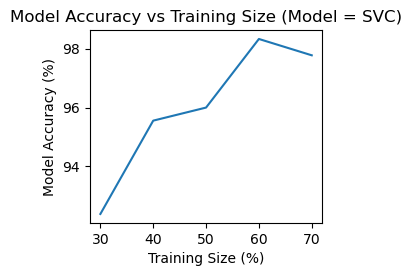

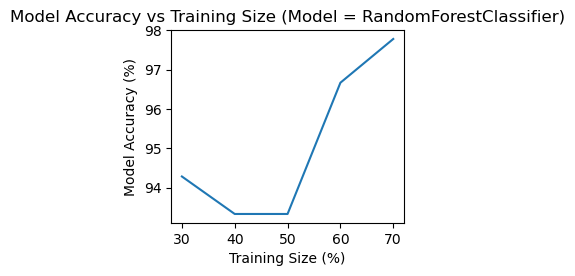

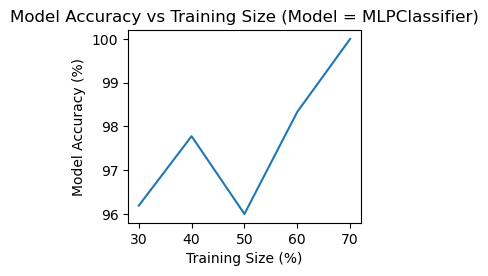

In [9]:
getTrainsizeAccuracies(iris_dataset,
                       SVC,
                       4)

getTrainsizeAccuracies(iris_dataset,
                       RandomForestClassifier,
                       4)

getTrainsizeAccuracies(iris_dataset,
                       MLPClassifier,
                       42,
                       max_iter=1000
                      )

#### Comparing Different Models for Iris Dataset

======================== Model = MLPClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.93      1.00      0.97        14
           2       1.00      0.92      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.98        45
weighted avg       0.98      0.98      0.98        45

---------------------------- Confusion Mtrix -------------------------


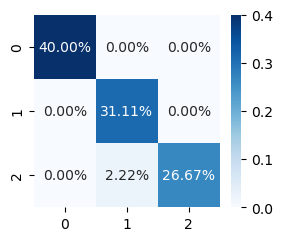




======================== Model = SVC ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.83      0.94      0.88        16
           2       0.94      0.85      0.89        20

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60

---------------------------- Confusion Mtrix -------------------------


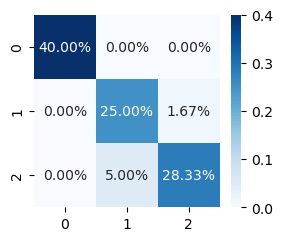




======================== Model = RandomForestClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.83      0.94      0.88        16
           2       0.94      0.85      0.89        20

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60

---------------------------- Confusion Mtrix -------------------------


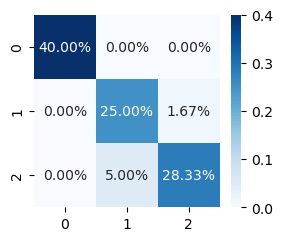

In [10]:
printClassficationReport(iris_dataset, MLPClassifier, 60, 0.7, max_iter=10000)
printClassficationReport(iris_dataset, SVC, 60, 0.6)
printClassficationReport(iris_dataset, RandomForestClassifier, 60, 0.6)

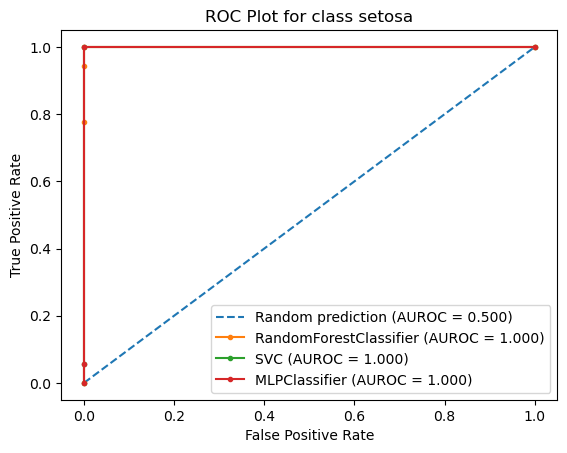

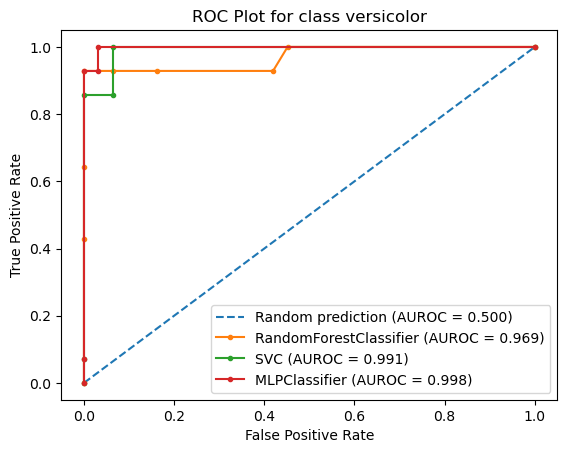

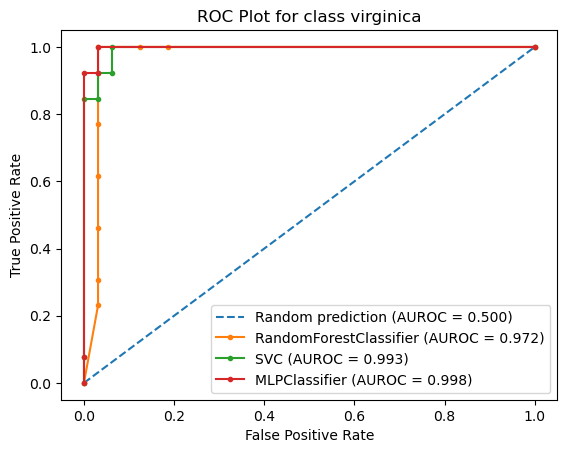

In [11]:
displayROCPlot(iris_dataset, 
               [RandomForestClassifier, SVC, MLPClassifier], 
               0.7, 
               60, 
               True, 
               RandomForestClassifier={}, 
               MLPClassifier={'max_iter':10000}, 
               SVC={'probability':True})

### Parameter tunning

In [12]:
iris_best_model_config = getModelScores(iris_dataset, model_params, 5)

In [13]:
iris_best_model_config

,model,best_score,best_params
0,RandomForestClassifier,0.966667,"{'criterion': 'gini', 'max_features': 'sqrt', ..."
1,MLPClassifier,0.986667,"{'activation': 'identity', 'alpha': 0.01, 'sol..."
2,SVC,0.980000,"{'coef0': 0, 'degree': 3, 'kernel': 'linear'}"


In [14]:
print(f"{iris_best_model_config['model'][0]} --> {iris_best_model_config['best_params'][0]}")
print(f"{iris_best_model_config['model'][1]} --> {iris_best_model_config['best_params'][1]}")
print(f"{iris_best_model_config['model'][2]} --> {iris_best_model_config['best_params'][2]}")

RandomForestClassifier --> {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 400}
MLPClassifier --> {'activation': 'identity', 'alpha': 0.01, 'solver': 'sgd'}
SVC --> {'coef0': 0, 'degree': 3, 'kernel': 'linear'}


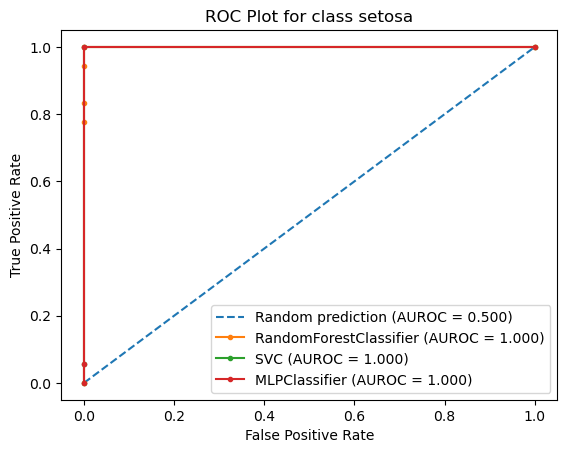

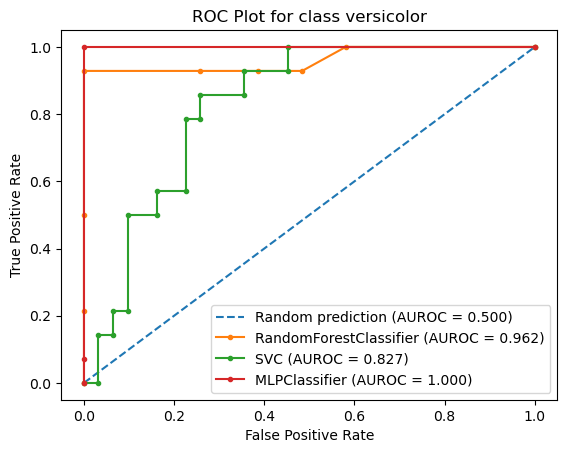

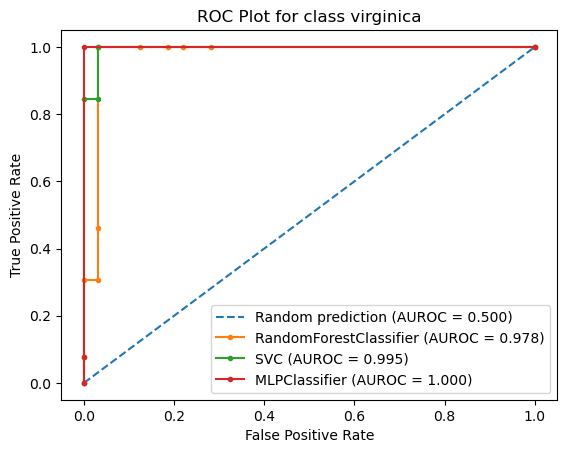

In [56]:
displayROCPlot(iris_dataset, 
               [RandomForestClassifier, SVC, MLPClassifier], 
               0.7, 
               60, 
               True, 
               RandomForestClassifier={'criterion': 'gini', 
                                       'max_features': 'sqrt', 
                                       'n_estimators': 400}, 
               
               MLPClassifier={
                               'max_iter':10000, 
                              'alpha': 0.001, 
                              'solver': 'sgd'}, 
               
               SVC={'probability':True, 
                    'coef0': 0, 
                    'degree': 3,
                    'kernel': 'linear'
                   })

======================== Model = MLPClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.93      1.00      0.97        14
           2       1.00      0.92      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.98        45
weighted avg       0.98      0.98      0.98        45

---------------------------- Confusion Mtrix -------------------------


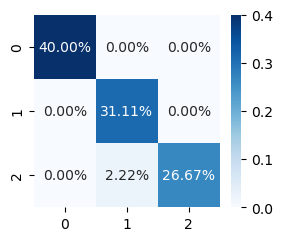




======================== Model = SVC ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.83      0.94      0.88        16
           2       0.94      0.85      0.89        20

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60

---------------------------- Confusion Mtrix -------------------------


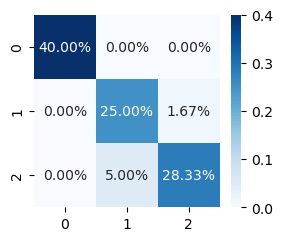




======================== Model = RandomForestClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.83      0.94      0.88        16
           2       0.94      0.85      0.89        20

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60

---------------------------- Confusion Mtrix -------------------------


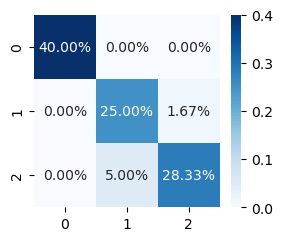

In [57]:
printClassficationReport(iris_dataset, MLPClassifier, 60, 0.7, max_iter=10000 )
printClassficationReport(iris_dataset, SVC, 60, 0.6)
printClassficationReport(iris_dataset, 
                         RandomForestClassifier, 
                         60, 0.6, 
                         criterion = 'gini', 
                         max_features = 'sqrt', 
                         n_estimators = 400)

### PCA

In [17]:
iris_dataset.data.shape

(150, 4)

In [18]:
iris_pca = PCA(0.95).fit_transform(iris_dataset.data)

In [19]:
iris_pca.shape

(150, 2)

In [20]:
iris_pca_dataset = Bunch( 
                            data=iris_pca, 
                            target=iris_dataset.target,
                            target_names=iris_dataset.target_names
                          )

======================== Model = MLPClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.93      0.93      0.93        14
           2       0.92      0.92      0.92        13

    accuracy                           0.96        45
   macro avg       0.95      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45

---------------------------- Confusion Mtrix -------------------------


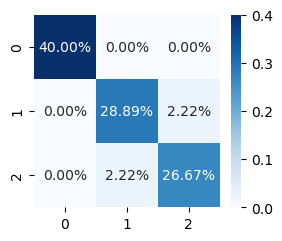




======================== Model = SVC ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.88      0.94      0.91        16
           2       0.95      0.90      0.92        20

    accuracy                           0.95        60
   macro avg       0.94      0.95      0.94        60
weighted avg       0.95      0.95      0.95        60

---------------------------- Confusion Mtrix -------------------------


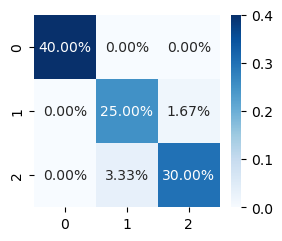




======================== Model = RandomForestClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       0.88      0.88      0.88        16
           2       0.90      0.90      0.90        20

    accuracy                           0.93        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.93      0.93      0.93        60

---------------------------- Confusion Mtrix -------------------------


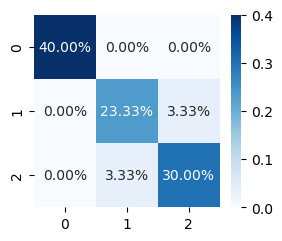

In [58]:
printClassficationReport(iris_pca_dataset, MLPClassifier, 60, 0.7, max_iter=10000 )
printClassficationReport(iris_pca_dataset, SVC, 60, 0.6)
printClassficationReport(iris_pca_dataset, RandomForestClassifier, 60, 0.6, 
                         criterion = 'gini', 
                         max_features = 'sqrt', 
                         n_estimators = 400)

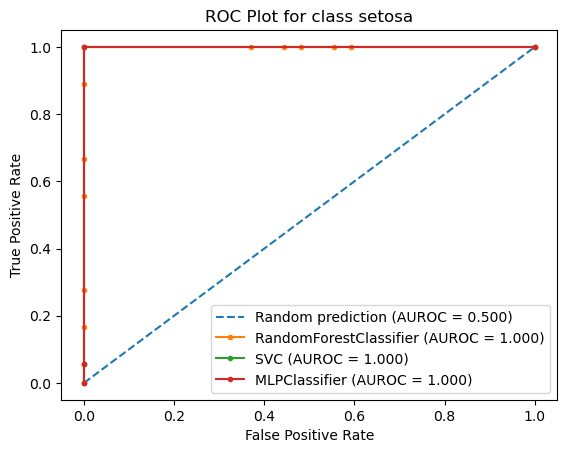

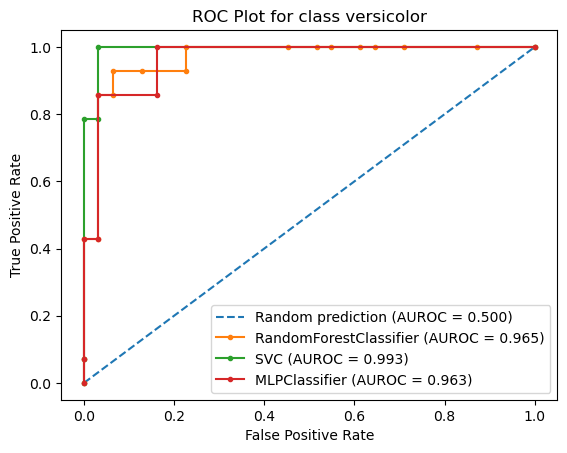

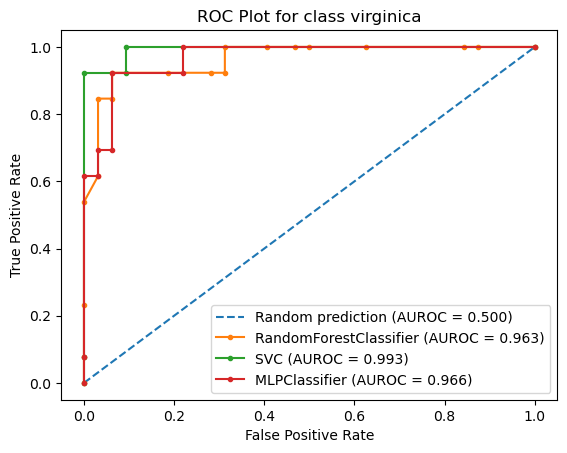

In [59]:
displayROCPlot(iris_pca_dataset, 
               [RandomForestClassifier, SVC, MLPClassifier], 
               0.7, 
               60, 
               True, 
               RandomForestClassifier={'criterion': 'gini', 
                                       'max_features': 'sqrt', 
                                       'n_estimators': 400}, 
               
               MLPClassifier={'max_iter':10000, 
                              'alpha': 0.001, 
                              'solver': 'sgd'}, 
               SVC={'probability':True, 
                    'coef0': 0, 
                    'degree': 3})

## Ionosphere Dataset

In [23]:
# downloading the Ionosphere dataset
!curl https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.csv -o data/ionosphere.csv

# Preparing data
ionosphere_df = pd.read_csv('data/ionosphere.csv', header=None)
ionosphere_dataset = Bunch( 
                            data=ionosphere_df.loc[:,0:33], 
                            target=np.where(ionosphere_df[34] == 'g', 0, 1)
                          )

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 76466  100 76466    0     0   144k      0 --:--:-- --:--:-- --:--:--  145k


### Without Parameter Tunning

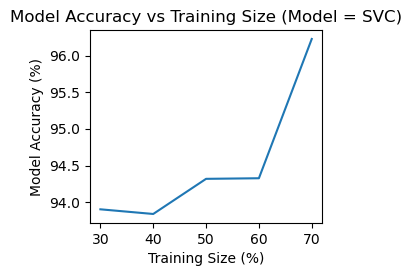

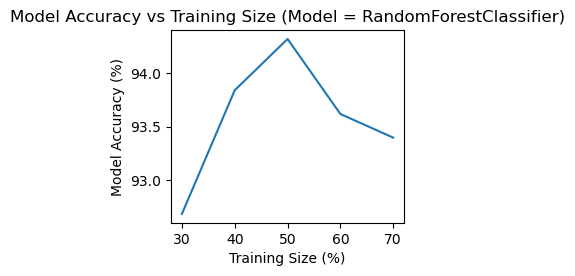

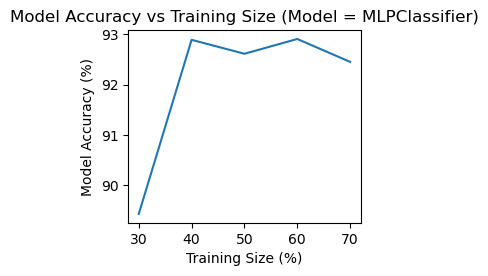

In [24]:
getTrainsizeAccuracies(ionosphere_dataset,
                       SVC, 4)

getTrainsizeAccuracies(ionosphere_dataset,
                       RandomForestClassifier,
                        4)

getTrainsizeAccuracies(ionosphere_dataset,
                       MLPClassifier,
                        4,
                        max_iter=1000 )

======================== Model = MLPClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       0.90      0.99      0.94        96
           1       0.97      0.76      0.85        45

    accuracy                           0.91       141
   macro avg       0.93      0.87      0.90       141
weighted avg       0.92      0.91      0.91       141

---------------------------- Confusion Mtrix -------------------------


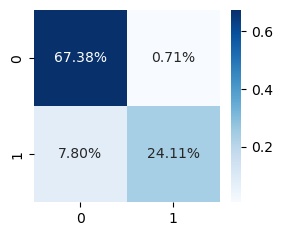




======================== Model = SVC ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       0.92      0.97      0.95        71
           1       0.94      0.83      0.88        35

    accuracy                           0.92       106
   macro avg       0.93      0.90      0.91       106
weighted avg       0.93      0.92      0.92       106

---------------------------- Confusion Mtrix -------------------------


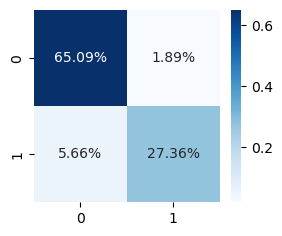




======================== Model = RandomForestClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        71
           1       0.93      0.77      0.84        35

    accuracy                           0.91       106
   macro avg       0.91      0.87      0.89       106
weighted avg       0.91      0.91      0.90       106

---------------------------- Confusion Mtrix -------------------------


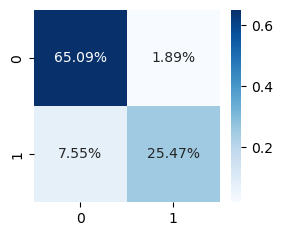

In [25]:
printClassficationReport(ionosphere_dataset, MLPClassifier, 60, 0.6, max_iter=10000) 
printClassficationReport(ionosphere_dataset, SVC, 60, 0.7) 
printClassficationReport(ionosphere_dataset, RandomForestClassifier, 60, 0.7)

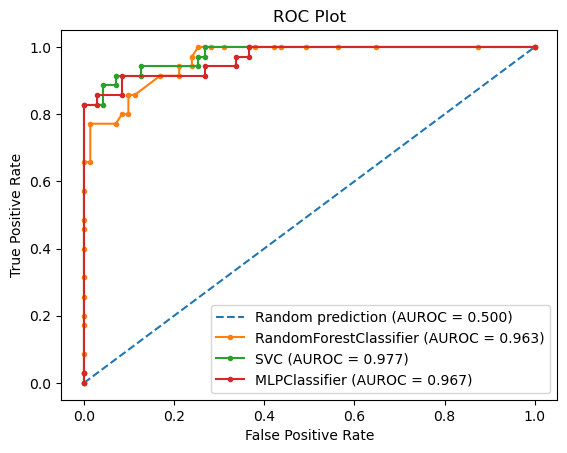

In [26]:
displayROCPlot(ionosphere_dataset, 
               [RandomForestClassifier, SVC, MLPClassifier], 
                0.7, 60, 
                RandomForestClassifier={}, 
                MLPClassifier={'max_iter':10000}, 
                SVC={'probability':True})

### Parameter tunning

In [27]:
ionosphere_best_model_config = getModelScores(ionosphere_dataset, model_params, 5)

In [28]:
ionosphere_best_model_config

,model,best_score,best_params
0,RandomForestClassifier,0.937344,"{'criterion': 'gini', 'max_features': 'sqrt', ..."
1,MLPClassifier,0.923179,"{'activation': 'relu', 'alpha': 0.01, 'solver'..."
2,SVC,0.934447,"{'coef0': 0, 'degree': 3, 'kernel': 'rbf'}"


In [29]:
print(f"{ionosphere_best_model_config['model'][0]} --> {ionosphere_best_model_config['best_params'][0]}")
print(f"{ionosphere_best_model_config['model'][1]} --> {ionosphere_best_model_config['best_params'][1]}")
print(f"{ionosphere_best_model_config['model'][2]} --> {ionosphere_best_model_config['best_params'][2]}")

RandomForestClassifier --> {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 200}
MLPClassifier --> {'activation': 'relu', 'alpha': 0.01, 'solver': 'adam'}
SVC --> {'coef0': 0, 'degree': 3, 'kernel': 'rbf'}


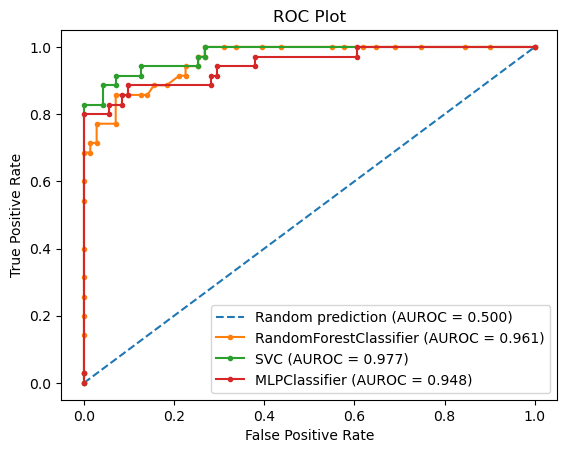

In [60]:
displayROCPlot(ionosphere_dataset,
               [RandomForestClassifier, SVC, MLPClassifier],
                0.7,
                60,
                RandomForestClassifier={'criterion': 'gini', 
                                        'max_features': 'sqrt', 
                                        'n_estimators': 200},
                MLPClassifier={
                                'max_iter':10000,
                                'activation': 'relu', 
                               'alpha': 0.01, 
                               'solver': 'adam'},
                SVC={'probability':True,
                    'coef0': 0, 
                     'degree': 3, 
                     'kernel': 'rbf'})

======================== Model = MLPClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        71
           1       1.00      0.80      0.89        35

    accuracy                           0.93       106
   macro avg       0.96      0.90      0.92       106
weighted avg       0.94      0.93      0.93       106

---------------------------- Confusion Mtrix -------------------------


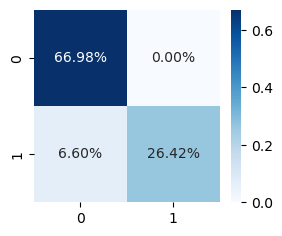




======================== Model = SVC ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       0.92      0.97      0.95        71
           1       0.94      0.83      0.88        35

    accuracy                           0.92       106
   macro avg       0.93      0.90      0.91       106
weighted avg       0.93      0.92      0.92       106

---------------------------- Confusion Mtrix -------------------------


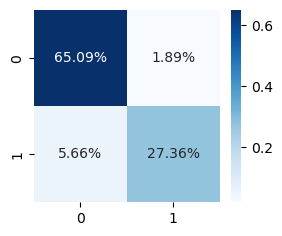




======================== Model = RandomForestClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        71
           1       0.87      0.77      0.82        35

    accuracy                           0.89       106
   macro avg       0.88      0.86      0.87       106
weighted avg       0.89      0.89      0.88       106

---------------------------- Confusion Mtrix -------------------------


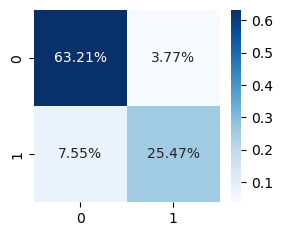

In [31]:
printClassficationReport(ionosphere_dataset, MLPClassifier, 60, 0.7, 
                         max_iter=10000, 
                         activation= 'relu', 
                        alpha= 0.0001, 
                        solver= 'adam')

printClassficationReport(ionosphere_dataset, SVC, 60, 0.7,
                        coef0= 0, 
                         degree= 3, 
                         kernel= 'rbf') 
printClassficationReport(ionosphere_dataset,
                        RandomForestClassifier, 60, 0.7,
                        criterion= 'entropy', 
                        max_features= 'log2', 
                        n_estimators= 200)

### PCA

In [32]:
ionosphere_dataset.data.shape

(351, 34)

In [33]:
ionosphere_pca = PCA(0.95).fit_transform(ionosphere_dataset.data)

In [34]:
ionosphere_pca.shape

(351, 24)

In [35]:
ionosphere_pca_dataset = Bunch(
                                data=ionosphere_pca, 
                                target=ionosphere_dataset.target
                            )

======================== Model = MLPClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        71
           1       1.00      0.74      0.85        35

    accuracy                           0.92       106
   macro avg       0.94      0.87      0.90       106
weighted avg       0.92      0.92      0.91       106

---------------------------- Confusion Mtrix -------------------------


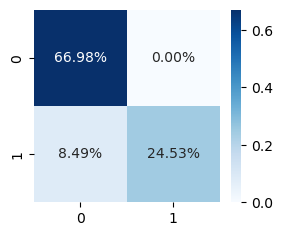




======================== Model = SVC ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       0.92      0.97      0.95        71
           1       0.94      0.83      0.88        35

    accuracy                           0.92       106
   macro avg       0.93      0.90      0.91       106
weighted avg       0.93      0.92      0.92       106

---------------------------- Confusion Mtrix -------------------------


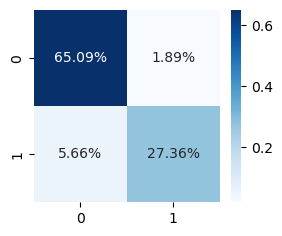




======================== Model = RandomForestClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        71
           1       0.92      0.94      0.93        35

    accuracy                           0.95       106
   macro avg       0.94      0.95      0.95       106
weighted avg       0.95      0.95      0.95       106

---------------------------- Confusion Mtrix -------------------------


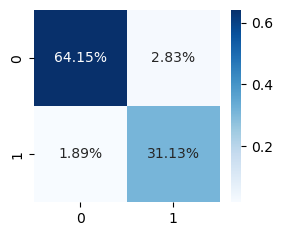

In [36]:
printClassficationReport(ionosphere_pca_dataset, MLPClassifier, 60, 0.7, 
                         max_iter=10000, 
                         activation= 'relu', 
                        alpha= 0.0001, 
                        solver= 'adam')

printClassficationReport(ionosphere_pca_dataset, SVC, 60, 0.7,
                        coef0= 0, 
                         degree= 3, 
                         kernel= 'rbf') 
printClassficationReport(ionosphere_pca_dataset,
                        RandomForestClassifier, 60, 0.7,
                        criterion= 'entropy', 
                        max_features= 'log2', 
                        n_estimators= 200)

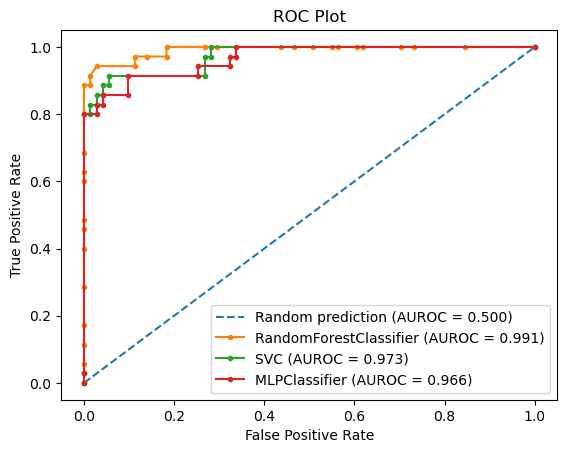

In [37]:
displayROCPlot(ionosphere_pca_dataset,
               [RandomForestClassifier, SVC, MLPClassifier],
                0.7,
                60,
                RandomForestClassifier={'criterion': 'entropy', 
                                        'max_features': 'log2', 
                                        'n_estimators': 200},
                MLPClassifier={
                                'max_iter':10000,
                                'activation': 'relu', 
                               'alpha': 0.0001, 
                               'solver': 'adam'},
                SVC={'probability':True,
                    'coef0': 0, 
                     'degree': 3, 
                     'kernel': 'rbf'})

## Wisconsin Breast Cancer Dataset

In [38]:
breast_cancer_dataset = load_breast_cancer()

### Without Parameter Tunning

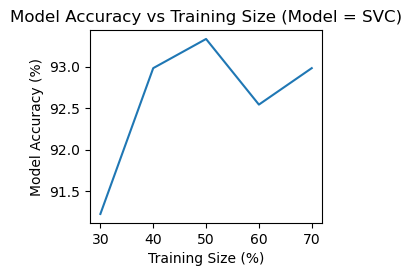

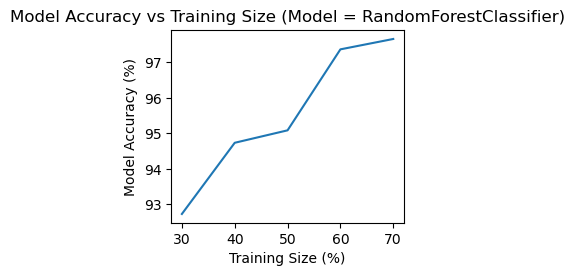

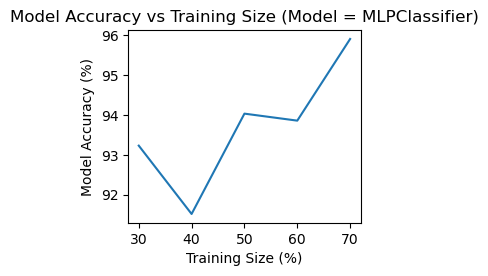

In [39]:
getTrainsizeAccuracies(breast_cancer_dataset,
                       SVC,
                        40)
getTrainsizeAccuracies(breast_cancer_dataset,
                       RandomForestClassifier,
                        40)
getTrainsizeAccuracies(breast_cancer_dataset,
                       MLPClassifier,
                        40,
                        max_iter=1000 )

======================== Model = MLPClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        60
           1       0.96      0.95      0.95       111

    accuracy                           0.94       171
   macro avg       0.93      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

---------------------------- Confusion Mtrix -------------------------


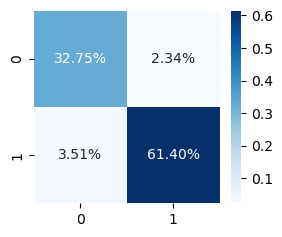




======================== Model = SVC ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       0.96      0.87      0.91        84
           1       0.93      0.98      0.95       144

    accuracy                           0.94       228
   macro avg       0.94      0.92      0.93       228
weighted avg       0.94      0.94      0.94       228

---------------------------- Confusion Mtrix -------------------------


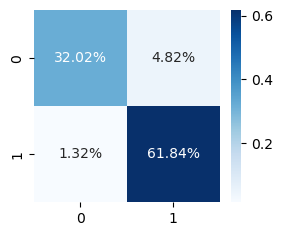




======================== Model = RandomForestClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        84
           1       0.99      0.97      0.98       144

    accuracy                           0.97       228
   macro avg       0.96      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228

---------------------------- Confusion Mtrix -------------------------


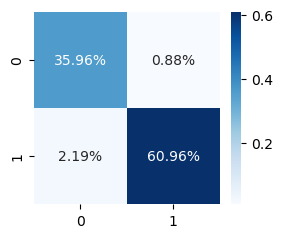

In [40]:
printClassficationReport(breast_cancer_dataset, MLPClassifier, 60, 0.7, max_iter=10000) 
printClassficationReport(breast_cancer_dataset, SVC, 60, 0.6) 
printClassficationReport(breast_cancer_dataset, RandomForestClassifier, 60, 0.6)

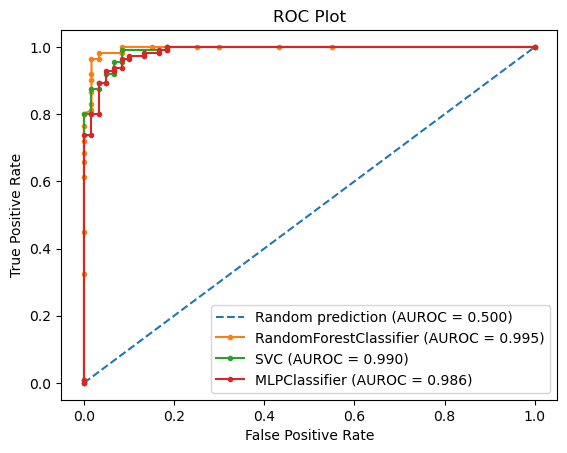

In [41]:
displayROCPlot(breast_cancer_dataset,
               [RandomForestClassifier, SVC, MLPClassifier],
                0.7,
                60,
                RandomForestClassifier={}, 
                MLPClassifier={'max_iter':10000}, 
                SVC={'probability':True})

### Parameter Tunning

In [42]:
scaled_breast_cancer_dataset = Bunch( 
                            data=StandardScaler().fit_transform(breast_cancer_dataset.data), 
                            target=breast_cancer_dataset.target
                          )

In [43]:
breast_cancer_best_model_config = getModelScores(scaled_breast_cancer_dataset, model_params, 5)

In [44]:
breast_cancer_best_model_config

,model,best_score,best_params
0,RandomForestClassifier,0.970129,"{'criterion': 'log_loss', 'max_features': 'sqr..."
1,MLPClassifier,0.984195,"{'activation': 'tanh', 'alpha': 0.0001, 'solve..."
2,SVC,0.980702,"{'coef0': 1, 'degree': 3, 'kernel': 'poly'}"


In [45]:
print(f"{breast_cancer_best_model_config['model'][0]} --> {breast_cancer_best_model_config['best_params'][0]}")
print(f"{breast_cancer_best_model_config['model'][1]} --> {breast_cancer_best_model_config['best_params'][1]}")
print(f"{breast_cancer_best_model_config['model'][2]} --> {breast_cancer_best_model_config['best_params'][2]}")

RandomForestClassifier --> {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 500}
MLPClassifier --> {'activation': 'tanh', 'alpha': 0.0001, 'solver': 'sgd'}
SVC --> {'coef0': 1, 'degree': 3, 'kernel': 'poly'}


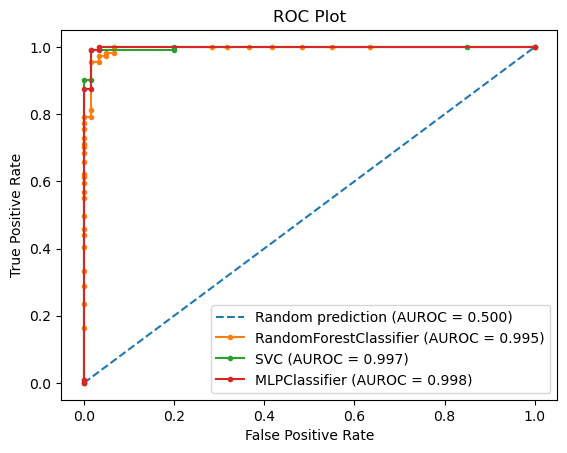

In [62]:
displayROCPlot(scaled_breast_cancer_dataset,
               [RandomForestClassifier, SVC, MLPClassifier],
                0.7,
                60,
                RandomForestClassifier={'criterion': 'log_loss', 
                                        'max_features': 'sqrt', 
                                        'n_estimators': 500},
                MLPClassifier={'activation': 'tanh', 
                               'alpha': 0.0001, 
                               'solver': 'adam',
                               'max_iter': 1000
                              },
                SVC={
                    'probability':True,
                    'coef0': 1, 
                     'degree': 3, 
                     'kernel': 'poly'
                    }
              )

======================== Model = MLPClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.98        60
           1       0.99      0.98      0.99       111

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

---------------------------- Confusion Mtrix -------------------------


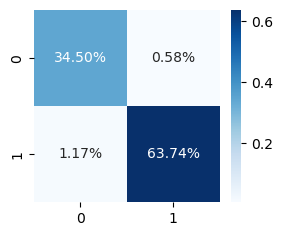




======================== Model = SVC ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        60
           1       0.99      0.97      0.98       111

    accuracy                           0.98       171
   macro avg       0.97      0.98      0.97       171
weighted avg       0.98      0.98      0.98       171

---------------------------- Confusion Mtrix -------------------------


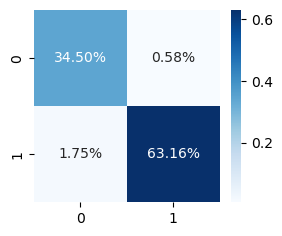




======================== Model = RandomForestClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        60
           1       0.98      0.97      0.98       111

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171

---------------------------- Confusion Mtrix -------------------------


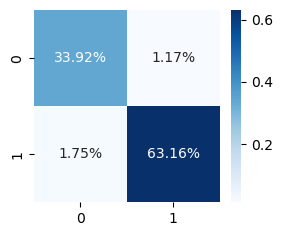

In [63]:
printClassficationReport(scaled_breast_cancer_dataset, MLPClassifier, 60, 0.7, 
                         activation= 'tanh', 
                         alpha= 0.0001, 
                         solver= 'adam',
                         max_iter= 1000)

printClassficationReport(scaled_breast_cancer_dataset, SVC, 60, 0.7,
                        coef0= 1, 
                        degree= 3, 
                        kernel= 'poly')

printClassficationReport(scaled_breast_cancer_dataset, RandomForestClassifier, 
                         60, 0.7,
                         criterion= 'log_loss', 
                          max_features= 'sqrt', 
                            n_estimators= 500)

In [48]:
scaled_breast_cancer_dataset.data.shape

(569, 30)

In [49]:
breast_cancer_pca = PCA(0.95).fit_transform(scaled_breast_cancer_dataset.data)

In [50]:
breast_cancer_pca.shape

(569, 10)

In [51]:
breast_cancer_pca_dataset = Bunch(
                            data=breast_cancer_pca, 
                            target=scaled_breast_cancer_dataset.target
                        )

======================== Model = MLPClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.98        60
           1       0.99      0.98      0.99       111

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

---------------------------- Confusion Mtrix -------------------------


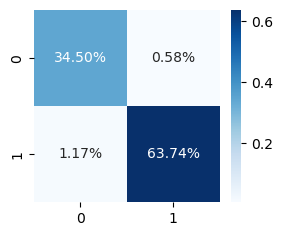




======================== Model = SVC ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        60
           1       0.99      0.99      0.99       111

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171

---------------------------- Confusion Mtrix -------------------------


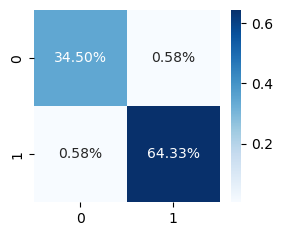




======================== Model = RandomForestClassifier ========================
------------------------- Classification Report ----------------------
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        60
           1       0.98      0.94      0.96       111

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

---------------------------- Confusion Mtrix -------------------------


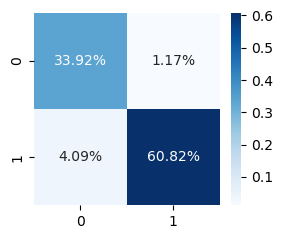

In [52]:
printClassficationReport(breast_cancer_pca_dataset, MLPClassifier, 60, 0.7, 
                         activation= 'logistic', 
                         alpha= 0.1, 
                         solver= 'adam',
                         max_iter= 1000)

printClassficationReport(breast_cancer_pca_dataset, SVC, 60, 0.7,
                        coef0= 1, 
                        degree= 3, 
                        kernel= 'poly')

printClassficationReport(breast_cancer_pca_dataset, RandomForestClassifier, 
                         60, 0.7,
                         criterion= 'entropy', 
                          max_features= 'log2', 
                            n_estimators= 300)

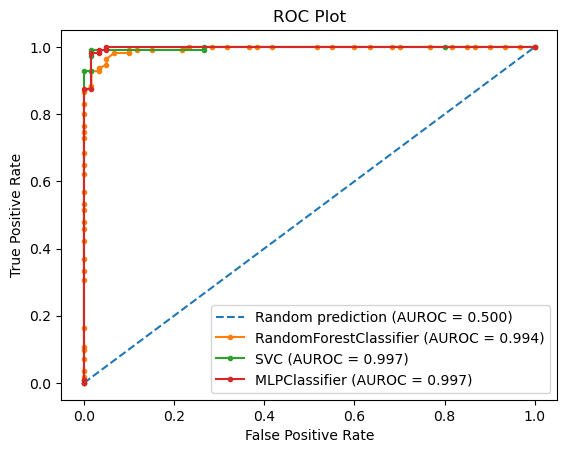

In [53]:
displayROCPlot(breast_cancer_pca_dataset,
               [RandomForestClassifier, SVC, MLPClassifier],
                0.7,
                60,
                RandomForestClassifier={'criterion': 'entropy', 
                                        'max_features': 'log2', 
                                        'n_estimators': 300},
                MLPClassifier={'activation': 'logistic', 
                               'alpha': 0.1, 
                               'solver': 'adam',
                               'max_iter': 1000
                              },
                SVC={
                    'probability':True,
                    'coef0': 1, 
                     'degree': 3, 
                     'kernel': 'poly'
                    }
              )